# ITAcademy - Data Science amb Python
# Sprint 5, Tasca 1: Anàlisi de logs amb Regex

In [162]:
import re

import pandas as pd
import numpy as np

from IPy import IP
from ip2geotools.databases.noncommercial import DbIpCity

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Introducció

L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel, i iniciar una resposta ràpida per mitigar els riscos.

Els fitxers de registre (*log files*, en anglès) són una eina estàndard per a desenvolupadors i administradors de sistemes informàtics. Enregistren el "què va passar quan i per qui" del sistema. Aquesta informació pot registrar errors i ajudar al seu diagnòstic. Com que el seu format està estandarditzat, els fitxers es poden analitzar fàcilment mitjançant una varietat de programes d'anàlisi web.

### NSCA Log Format

El format de registre NSCA és un format de fitxer de text estandarditzat utilitzat pels servidors web en generar fitxers de registre de servidors. Es basa en el NCSA httpd, i és àmpliament acceptat com a estàndard entre els proveïdors del servidor HTTP.

El format de registre comú NSCA (*NSCA Common log format*) conté el recurs sol·licitat i algunes altres peces d'informació, però no conté informació de referència, agent d'usuari o galetes. Per altra banda, el format de registre combinat NCSA (*NSCA Combined log format*) és una extensió del format de registre comú NCSA, i conté tres camps addicionals i opcionals: el camp de referència, el camp user_agent i el camp de galetes.

Els camps del Combined log format són:
> `host rfc931 username date:time request statuscode bytes referrer user_agent cookie`

El següent exemple mostra cadasqun d'aquests camps amb valors assignats:
> `125.125.125.125 - dsmith [10/Oct/1999:21:15:05 +0500] "GET /index.html HTTP/1.0" 200 1043 "http://www.ibm.com/" "Mozilla/4.05 [en] (WinNT; I)" "USERID=CustomerA;IMPID=01234"`

A continuació farem una descripció en anglès de cadascun del camps en el Combined log Format:

|Field|Description|Example|
|---|---|---
|**host/ip**|The IP address or host/subdomain name of the HTTP client that made the HTTP resource request.|125.125.125.125|
|**rfc931**|The identifier used to identify the client making the HTTP request. If no value is present, a "-" is substituted.|"-"|
|**username**|The username, (or user ID) used by the client for authentication. If no value is present, a "-" is substituted.|dsmith|
|**date:time timezone**|The date and time stamp of the HTTP request. *1|[10/Oct/1999:21:15:05 +0500]|
|**request**|The HTTP request. The request field contains three pieces of information. The main piece is the requested resource (index.html). The request field also contains the HTTP method (GET) and the HTTP protocol version (1.0).|"GET /index.html HTTP/1.0"|
|**status**|The status is the numeric code indicating the success or failure of the HTTP request.|200|
|**bytes**|The bytes field is a numeric field containing the number of bytes of data transferred as part of the HTTP request, not including the HTTP header.|1043|
|**referrer**|The URL which linked the user to your site. (Optional)|"http://www.ibm.com/"|
|**user_agent**|The Web browser and platform used by the visitor to your site.(Optional)|"Mozilla/4.05 [en] (WinNT; I)"|
|**cookies**|Cookies are pieces of information that the HTTP server can send back to client along the with the requested resources. A client's browser may store this information and subsequently send it back to the HTTP server upon making additional resource requests. The HTTP server can establish multiple cookies per HTTP request. *2 |"USERID=CustomerA;IMPID=01234"|

**[1]** The fields in the date/time field are  
> `[dd/MMM/yyyy:hh:mm:ss +-hhmm]`  
where the fields are defined as follow:
* dd is the day of the month
* MMM is the month
* yyy is the year
* :hh is the hour
* :mm is the minute
* :ss is the seconds
* +-hhmm is the time zone

**[2]** Cookies take the form KEY = VALUE. Multiple cookie key-value pairs are delineated by semicolons(;). If your HTTP server's logging configuration indicates to log cookies, then each cookie that the HTTP server contains for the requested resource is logged.

## Exercici 1

Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [178]:
pattern = r" (.+|-) (.+|-) (.+|-) \[(.*) \+0100\] (.+) (\d+|-) (\d+|-) \"(.+)\" \"(.+)\" VLOG="
columns = ["host", "ip", "rfc931", "username", "date", "request", "statuscode", "bytes", "referrer", "user_agent", "cookies"]

logs = pd.read_csv("Web_access_log-akumenius.com.txt", 
                   delimiter=pattern, 
                   engine="python",
                   names=columns,
                   na_values="-"
                   )
                   
logs.sample(10)

,host,ip,rfc931,username,date,request,statuscode,bytes,referrer,user_agent,cookies
254879,www.akumenius.com,88.6.202.244,NaN,NaN,01/Mar/2014:17:36:18,"""GET //libraries/anythingSlider/images/3a.png ...",200,2530.0,http://www.akumenius.com/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN
129644,www.akumenius.com,62.117.197.230,NaN,NaN,25/Feb/2014:18:27:30,"""GET /modules/raton/views/themes/bcoos/images/...",200,569.0,http://www.akumenius.com/hotel-list,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN
226874,www.akumenius.com,157.56.229.244,NaN,NaN,28/Feb/2014:03:48:40,"""GET /libraries/jqueryui/css/ui-lightness/jque...",200,1358.0,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,NaN
83513,www.akumenius.com,83.55.22.4,NaN,NaN,24/Feb/2014:20:20:04,"""POST /raton-search HTTP/1.1""",200,26.0,http://www.akumenius.com/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN
53380,www.akumenius.com,66.249.76.216,NaN,NaN,24/Feb/2014:11:05:04,"""GET /destinosCaracteristicas/hoteles-baratos-...",200,7203.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN
90032,www.akumenius.com,83.56.168.143,NaN,NaN,25/Feb/2014:00:42:31,"""GET /modules/raton/views/themes/bcoos/images/...",200,3638.0,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4)...,NaN
58074,test.akumenius.com,80.28.221.123,NaN,NaN,24/Feb/2014:12:34:29,"""GET /newdesign/includes/css/style.css HTTP/1.1""",304,NaN,http://test.akumenius.com/newdesign/destinosEs...,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,NaN
239616,www.akumenius.com,88.11.220.102,NaN,NaN,28/Feb/2014:19:36:15,"""GET /modules/raton/views/themes/bcoos/images/...",200,6497.0,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN
53996,www.akumenius.com,90.174.1.160,NaN,NaN,24/Feb/2014:11:26:45,"""GET /libraries/jqueryui/css/ui-lightness/jque...",200,4062.0,http://www.akumenius.com/,Mozilla/5.0 (Linux; Android 4.1.2; LG-E975 Bui...,NaN
212919,www.akumenius.com,95.63.1.210,NaN,NaN,27/Feb/2014:17:17:38,"""GET /modules/raton/views/themes/bcoos/images/...",200,2137.0,http://www.akumenius.com/escapadas/general-550...,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,NaN


## Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [179]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   host        261873 non-null  object 
 1   ip          261873 non-null  object 
 2   rfc931      0 non-null       float64
 3   username    27 non-null      object 
 4   date        261873 non-null  object 
 5   request     261873 non-null  object 
 6   statuscode  261873 non-null  int64  
 7   bytes       219538 non-null  float64
 8   referrer    162326 non-null  object 
 9   user_agent  261654 non-null  object 
 10  cookies     0 non-null       float64
dtypes: float64(3), int64(1), object(7)
memory usage: 22.0+ MB


Prescindim de les columnes "rfc931" i "cookies" al no disposar de cap valor.

In [180]:
logs.drop(columns=["rfc931", "cookies"], inplace=True, axis=1)

### Host

In [181]:
print(logs["host"].unique())

['localhost' 'www.akumenius.com' 'akumenius.com' 'akumenius.es'
 'test.akumenius.com']


Tenim cuatre identificadors de host.

### Username

In [182]:
print(logs["username"].unique())

[nan 'clarcat']


Només podem identificar a l'usuari "clarcat". La resta d'usuaris son anònims.

### Date

Els logs abasten un rang d'una setmana, de diumenge a diumenge. Els logs de tant el primer dia, 24 de febrer, com de l'últim, 3 de març, no comprenen les 24h del dia. Això afectarà les estadístiques posteriors corresponents a aquests dies.

Formategem la columna *date*, convertint-la de tipus `object` a tipus `datetime64`.

In [183]:
logs["date"] = pd.to_datetime(logs["date"], format="%d/%b/%Y:%H:%M:%S")
logs["date"]

0        2014-02-23 03:10:31
1        2014-02-23 03:10:31
2        2014-02-23 03:10:31
3        2014-02-23 03:10:31
4        2014-02-23 03:10:31
                 ...        
261868   2014-03-02 03:05:39
261869   2014-03-02 03:09:52
261870   2014-03-02 03:10:18
261871   2014-03-02 03:10:18
261872   2014-03-02 03:10:18
Name: date, Length: 261873, dtype: datetime64[ns]

Separem la columna *date* en dos components, date i time, rescrivint la mateixa columna *date* i creant una de nova anomenada *time*.

In [184]:
logs.insert((logs.columns.get_loc("date")+1), column="time", value=(logs["date"].dt.time))
logs["date"] = logs["date"].dt.date
logs.sample(5)

,host,ip,username,date,time,request,statuscode,bytes,referrer,user_agent
95370,www.akumenius.com,193.145.201.52,NaN,2014-02-25,09:15:08,"""GET /modules/raton/views/themes/bcoos/images/...",304,NaN,http://www.akumenius.com/hotel-list/30862/EP/E...,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...
65884,www.akumenius.com,87.111.221.104,NaN,2014-02-24,13:22:32,"""POST /destinos-insert HTTP/1.1""",200,26.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
105452,www.akumenius.com,77.231.88.149,NaN,2014-02-25,13:11:19,"""GET /modules/raton/views/themes/bcoos/images/...",200,9139.0,http://www.akumenius.com/hotel-list/31520/EP/E...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
173726,www.akumenius.com,81.39.110.171,NaN,2014-02-26,19:26:25,"""GET /includes/images/uploaded/logo.png HTTP/1.1""",304,NaN,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
137484,www.akumenius.com,83.230.226.4,NaN,2014-02-25,20:33:43,"""GET /includes/images/uploaded/Slideshow/ESC-R...",200,42972.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


Els logs es van registrar des del 23 de febrer de 2014 fins al 2 de març de 2014.

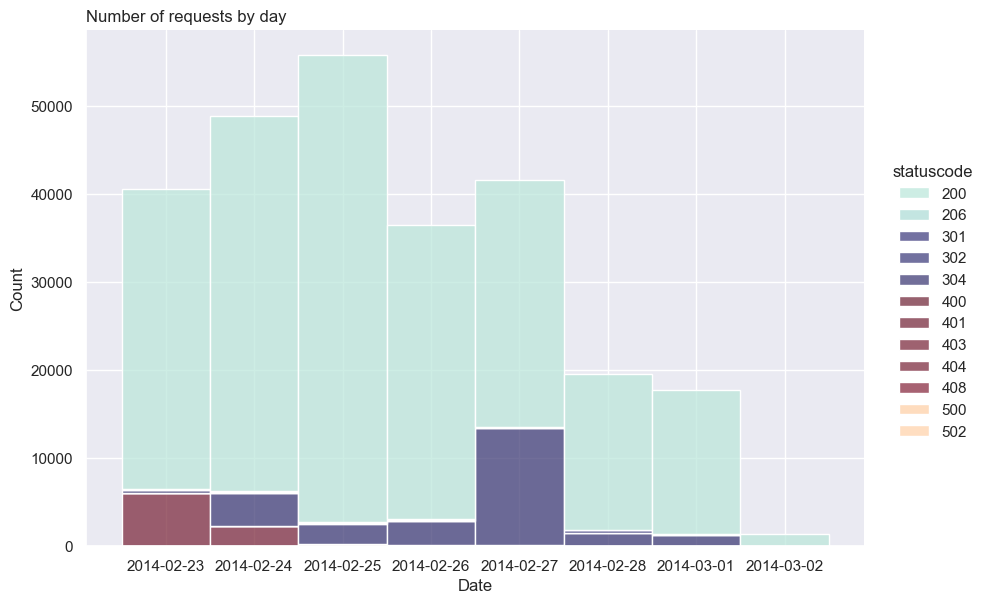

In [185]:
sns.displot(data=logs, x="date", kind="hist", 
            hue="statuscode", multiple="stack",
            height=6, aspect=1.5, palette="icefire")

plt.title("Number of requests by day", loc="left")

plt.xlabel("Date")

plt.show()

Els primers dos dies trobem alguns error dels clients, però desapareixen al tercer dia. Altres problemes presentats són marginals.

In [186]:
df_time = logs[["date", "time", "ip"]].copy()
df_time["date"] = df_time["date"].apply(lambda x: str(x))
df_time["time"] = df_time["time"].apply(lambda x: x.hour)
df_time.rename(columns={"date":"day", "time":"hour", "ip":"requests"}, inplace=True)
df_time = df_time.groupby(["hour", "day"]).count()
df_time

requests
hour day                 
0    2014-02-24      1259
     2014-02-25      1026
     2014-02-26      2281
     2014-02-27      1090
     2014-02-28      1653
...                   ...
23   2014-02-25      1396
     2014-02-26      1888
     2014-02-27      1166
     2014-02-28       439
     2014-03-01       691

[169 rows x 1 columns]

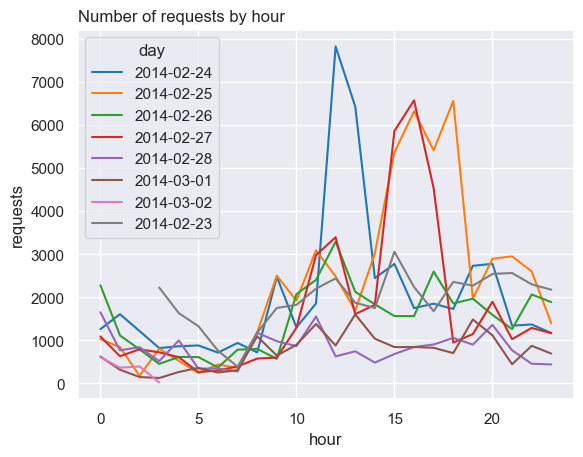

In [187]:
sns.lineplot(data=df_time, x="hour", y="requests",
             hue="day",
             palette="tab10")

plt.title("Number of requests by hour", loc="left")

plt.show()

El dilluns, dimarts i dijous trobem un augment significatiu del trànsit entre les 11h i les 18h. Durant la resta de la setmana, el trànsit es manté similar, sent tant divendres com dissabtes els dies amb menys sol·licituds.

### Request

Separem en un nou dataframe els diversos components de la columna request:
* Method
* Resource
* Protocol

In [188]:
df_request = logs["request"].str.extract(r"\"(?P<method>\w*) (?P<resource>[\/*].*?) (?P<protocol>.*?)\"")
df_request.sample(10)

,method,resource,protocol
200102,GET,/destinos-caracteristicas/hoteles-baratos-en-O...,HTTP/1.1
94641,GET,/chollos,HTTP/1.0
21232,GET,/modules/raton/views/themes/bcoos/images/star.png,HTTP/1.1
220078,GET,/includes/images/uploaded/ti_home.jpg,HTTP/1.1
169961,GET,/libraries/anythingSlider/includes/images/cell...,HTTP/1.1
229757,GET,/modules/raton/views/themes/bcoos/images/telef...,HTTP/1.1
117579,GET,//modules/raton/views/themes/bcoos/images/foto...,HTTP/1.1
181430,POST,/raton-search,HTTP/1.1
70409,GET,/hotels-consulted-update,HTTP/1.0
45986,GET,/libraries/jqueryui/js/jquery.ui.mouse.min.js,HTTP/1.1


In [189]:
df_request["method"].value_counts()

GET        229482
POST        16669
OPTIONS     13892
HEAD         1788
Name: method, dtype: int64

In [190]:
df_request["protocol"].value_counts()

HTTP/1.1    241991
HTTP/1.0     19840
Name: protocol, dtype: int64

### Statuscode

**Llista dels codis d'estat HTTP**
* 1xx Respotes informativas - petició rebuda, es continua el procés
* 2xx Respostes satisfactòries - petició rebuda, entesa i acceptada amb èxit
* 3xx Redireccions - cal prendre més mesures per completar la petició
* 4xx Errors del clients - la petició conté una sintaxi incorrecta o no es pot complir
* 5xx Error dels servidors – el servidor no ha pogut complir una petició aparentment vàlida

In [191]:
# Unique values of statuscode and sort index ascending
print(np.sort(logs["statuscode"].unique()))

[200 206 301 302 304 400 401 403 404 408 500 502]


In [192]:
logs["statuscode"].value_counts()

200    226382
304     25269
404      8630
301       870
206       304
403       194
302       109
502        44
408        37
400        26
401         5
500         3
Name: statuscode, dtype: int64

La gran majoria de peticions es van resoldre correctament. Anirem a descriure quins han siguts els errors més freqüents:
* `404 Not Found` - El servidor no va poder encontrar el contingut sol·licitat (~3,81% de les entrades). 
* `403 Forbidden` - El client no posseïa els permisos necessaris per a un cert contingut, per la qual cosa el servidor va rebutjar atorgar una resposta apropiada (~0,08% de les entrades).
* `502 Bad Gateway` - El servidor  va obtenir una resposta invàlida mentres treballava com una porta d'enllaç per a obtenir una resposta necessària per a manejar la petició (~0,02% de les entrades).


### Bytes

In [155]:
logs["bytes"].describe().apply(lambda x: format(x, 'f'))

count      219538.000000
mean        11827.712902
std        241363.023805
min             1.000000
25%          2510.000000
50%          6407.000000
75%          9674.000000
max      45564687.000000
Name: bytes, dtype: object

In [210]:
df_bytes = logs[["date", "bytes"]].groupby("date").sum().apply(lambda x: x/1024/1024)
df_bytes.rename(columns={"bytes":"MB"}, inplace=True)

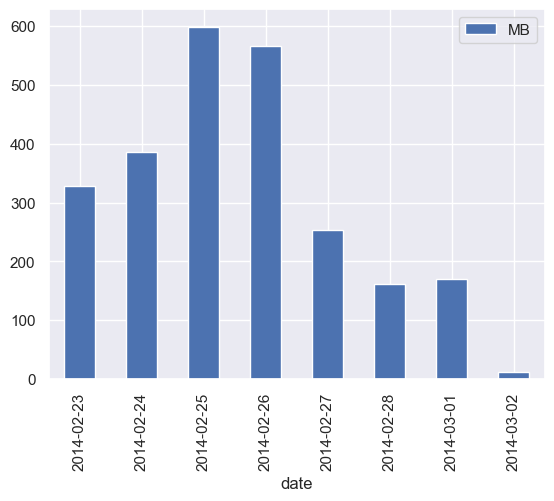

In [211]:
df_bytes.plot(kind="bar")
plt.show()

### Referrer

In [156]:
logs["referrer"].unique().size

2507

### User agent

In [157]:
logs["user_agent"].unique().size

735

## Exercici 3
Geolocalitza les IP's.

Creem un nou dataframe amb les 200 IPs que hagin fet més peticions i les geolocalitzem mitjançant l'API DbIpCity.

In [158]:
df_ip = logs["ip"].value_counts().head(200).rename_axis('ip').reset_index(name='count')
df_ip

,ip,count
0,66.249.76.216,46382
1,80.28.221.123,14725
2,127.0.0.1,13892
3,217.125.71.222,5201
4,66.249.75.148,3558
...,...,...
195,37.14.176.250,179
196,87.218.127.253,178
197,79.157.249.69,177
198,77.27.141.43,177


In [159]:
df_ip["type"] = df_ip["ip"].apply(lambda x: IP(x).iptype())
df_ip["type"].value_counts()

PUBLIC      199
LOOPBACK      1
Name: type, dtype: int64

Només incluirem IPs públiques. La IP 127.0.0.1 correspon al LOCALHOST, pel que no l'incluirem.

In [160]:
df_ip = df_ip[df_ip["type"] == "PUBLIC"]

Definim la funció `get_geolocalization()` per obtenir de l'API l'informació desitjada.

In [163]:
def get_geolocalization(ip):
    petition = DbIpCity.get(ip, api_key="free")
    return pd.Series([petition.latitude, petition.longitude, petition.city, petition.region, petition.country])

df_ip[['latitude', 'longitude', 'city', 'region', 'country']] = df_ip["ip"].apply(get_geolocalization)

C:\Users\Abel\anaconda3\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [164]:
df_ip

,ip,count,type,latitude,longitude,city,region,country
0,66.249.76.216,46382,PUBLIC,37.389389,-122.083210,Mountain View,California,US
1,80.28.221.123,14725,PUBLIC,40.416705,-3.703582,Madrid,Madrid,ES
3,217.125.71.222,5201,PUBLIC,40.416705,-3.703582,Madrid,Madrid,ES
4,66.249.75.148,3558,PUBLIC,37.389389,-122.083210,Mountain View,California,US
5,162.243.192.191,2927,PUBLIC,40.712728,-74.006015,New York,New York,US
...,...,...,...,...,...,...,...,...
195,37.14.176.250,179,PUBLIC,40.434653,-3.814834,Pozuelo de Alarcón,Madrid,ES
196,87.218.127.253,178,PUBLIC,40.434653,-3.814834,Pozuelo de Alarcón,Madrid,ES
197,79.157.249.69,177,PUBLIC,40.416705,-3.703582,Madrid,Madrid,ES
198,77.27.141.43,177,PUBLIC,42.237660,-8.724721,Vigo,Galicia,ES


In [165]:
dummy = df_ip.copy()

## Exercici 4
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.



En aquest últim exercici geocodificarem les dades de localització obtingudes a l'exercici anterior. Utilitzarem el paquet `geopandas`.

> *Geocodificació és el procés d'assignar coordenades geogràfiques (per exemple latitud-longitud) a punts del mapa (adreces, punts d'interès, etc.). Les coordenades geogràfiques produïdes poden després ser usades per localitzar el punt del mapa en un Sistema d'Informació Geogràfica.* — Wikipedia

In [166]:
import geopandas as gpd

Com volem renderitzar un mapa del mon, necessitarem un fitxer amb les coordenades de cadascun del països. *NaturalEarth* és un dataset de mapes de domini públic que proporciona dades geoespacials en diverses resolucions. En aquesta ocasió, escollirem les dades a escala 1:110m.

In [334]:
shapefile = 'natural-earth-vector/110m_cultural/ne_110m_admin_0_countries.shp'

df_geo = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
df_geo.columns = ['country_name', 'country_code', 'geometry']

# Drop the row for ‘Antarctica’ as it unnecessarily occupies a large space in our map
df_geo = df_geo.drop(df_geo.index[159]) 

df_geo

,country_name,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...
172,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


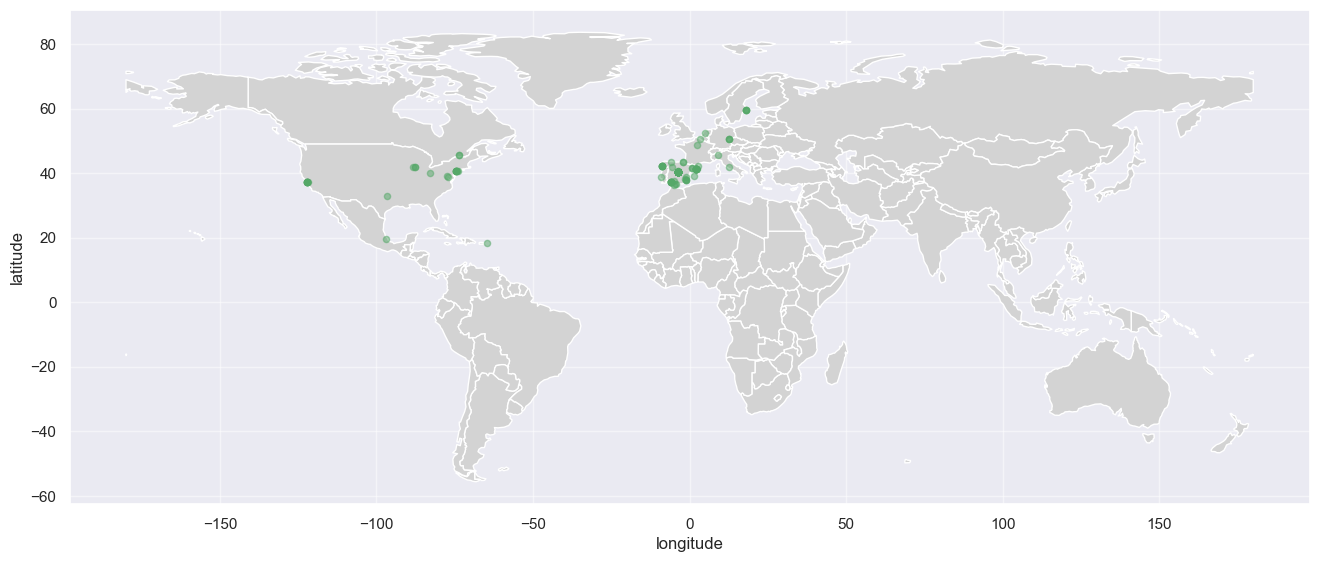

In [336]:
fig, ax = plt.subplots(figsize=(16,10))

df_geo.plot(color="lightgrey", ax=ax)

df_ip.plot(x="longitude", y="latitude", kind="scatter", 
        c="g", alpha=0.5, 
        ax=ax)

ax.grid(b=True, alpha=0.5)
plt.show()

El codi de país del dataset `df_geo` està definit en `ISO 3166-1 alpha-3`, mentres que de l'API de DB-IP està definit en `ISO 3166-1 alpha-2`. Formategem el dataframe `df_ip` perquè coincideixin.

In [337]:
countries_code = pd.read_csv('countries_code.csv', sep=':', header=None).T
countries_code.columns = ['country', 'country_code']
countries_code

,country,country_code
0,AD,AND
1,AE,ARE
2,AF,AFG
3,AG,ATG
4,AI,AIA
...,...,...
245,YE,YEM
246,YT,MYT
247,ZA,ZAF
248,ZM,ZMB


In [338]:
df_geo = pd.merge(df_geo, countries_code, on='country_code', how='outer')
df_geo

,country_name,country_code,geometry,country
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US
...,...,...,...,...
251,NaN,VIR,None,VI
252,NaN,WLF,None,WF
253,NaN,WSM,None,WS
254,NaN,XKX,None,XK


In [339]:
df_geo = pd.merge(df_geo, df_ip.groupby('country').count().ip, on='country', how="outer")
df_geo.rename(columns={'ip':'IPs'}, inplace=True)
df_geo.IPs.fillna(0, inplace=True)

,country_name,country_code,geometry,country,IPs
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,0.0
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ,0.0
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,0.0
3,Namibia,NAM,"POLYGON ((19.89577 -24.76779, 19.89473 -28.461...",NaN,0.0
4,Palestine,PSX,"POLYGON ((35.39756 31.48909, 34.92741 31.35344...",NaN,0.0
...,...,...,...,...,...
251,NaN,VIR,None,VI,0.0
252,NaN,WLF,None,WF,0.0
253,NaN,WSM,None,WS,0.0
254,NaN,XKX,None,XK,0.0


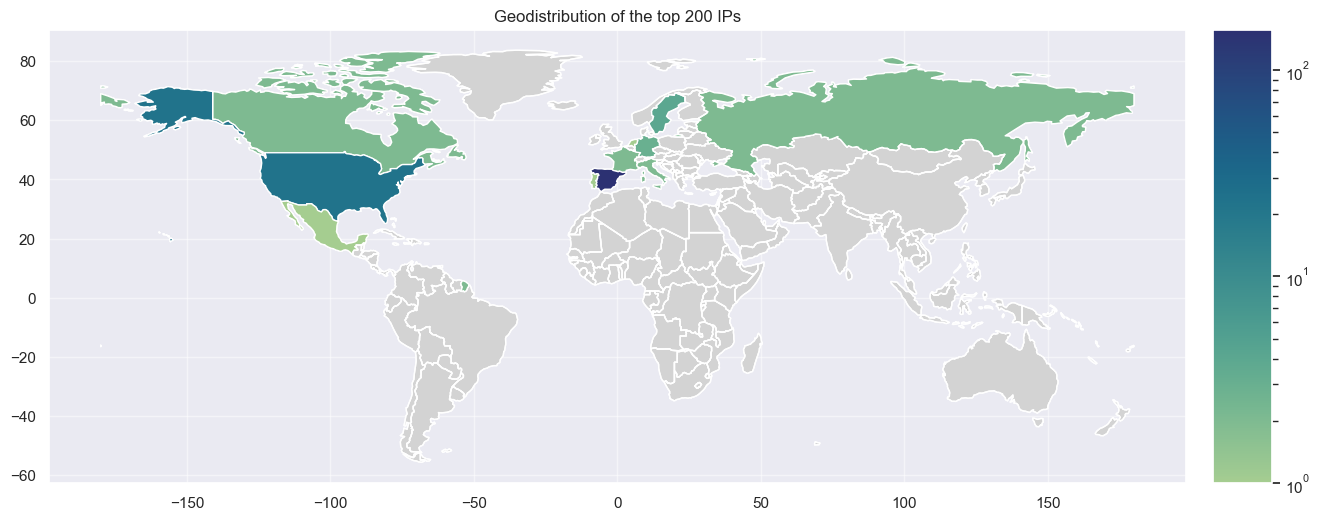

In [345]:
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16,12))

df_geo.plot(color="lightgrey", ax=ax)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_geo.plot(column='IPs', 
           legend=True, 
           ax=ax, 
           norm=colors.LogNorm(vmin=df_geo.IPs.min()+1, 
                               vmax=df_geo.IPs.max()),
           cmap='crest',
           cax=cax
           );

ax.grid(b=True, alpha=0.5)
ax.set_title('Geodistribution of the top 200 IPs')

plt.show()